In [63]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point

# Weather Station features

In [12]:
base_url = 'https://api.weather.gc.ca/collections/climate-stations/items'
complete_url = f'{base_url}?&PROV_STATE_TERR_CODE=BC'
response = requests.get(base_url)
station_data = response.json()
for station in station_data:
    print(station)

type
features
numberMatched
numberReturned
links
timeStamp


## Number of weather stations in Canada

In [11]:
base_url = 'https://api.weather.gc.ca/collections/climate-stations/items'
response = requests.get(base_url)
station_data = response.json()
print(station_data['numberMatched'], station_data['numberReturned'])

8552 500


## Number of weather stations in BC

In [13]:
base_url = 'https://api.weather.gc.ca/collections/climate-stations/items?&PROV_STATE_TERR_CODE=BC'
response = requests.get(base_url)
station_data = response.json()
print(station_data['numberMatched'], station_data['numberReturned'])

1750 500


## Number of weather stations in Metro Vancovuer

In [121]:
base_url = 'https://api.weather.gc.ca/collections/climate-stations/items'
complete_url = f'{base_url}?&bbox=-123.264,49.002,-122.313,49.494&STN_ID=731'
response = requests.get(complete_url)
station_data = response.json()
print(station_data['numberMatched'], station_data['numberReturned'])

1 1


In [122]:
station_data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'STN_ID': 731,
    'STATION_NAME': 'BURNABY SIMON FRASER U',
    'PROV_STATE_TERR_CODE': 'BC',
    'ENG_PROV_NAME': 'BRITISH COLUMBIA',
    'FRE_PROV_NAME': 'COLOMBIE-BRITANNIQUE',
    'COUNTRY': 'CAN',
    'LATITUDE': 491642200,
    'LONGITUDE': -1225504960,
    'TIMEZONE': 'PST',
    'ELEVATION': '365.80',
    'CLIMATE_IDENTIFIER': '1101158',
    'TC_IDENTIFIER': None,
    'WMO_IDENTIFIER': None,
    'STATION_TYPE': 'Climate-Staffed',
    'NORMAL_CODE': 'A',
    'PUBLICATION_CODE': 1,
    'DISPLAY_CODE': 1,
    'ENG_STN_OPERATOR_ACRONYM': 'CCN',
    'FRE_STN_OPERATOR_ACRONYM': 'RCSC',
    'ENG_STN_OPERATOR_NAME': 'Co-operative Climate Network',
    'FRE_STN_OPERATOR_NAME': 'Réseau coopératif de stations climatiques',
    'FIRST_DATE': '1965-01-01 00:00:00',
    'LAST_DATE': '2022-06-04 00:00:00',
    'HLY_FIRST_DATE': None,
    'HLY_LAST_DATE': None,
    'DLY_FIRST_DATE': '1965-02-01 00:00:00',
    'DLY

# Extracting features of Climate Stations

In [43]:
columns = station_data['features'][0]['properties'].keys()
values = [list(station_data['features'][i]['properties'].values()) for i in range(len(station_data['features']))]
dataframe = pd.DataFrame(values, columns=columns)
dataframe.columns

Index(['STN_ID', 'STATION_NAME', 'PROV_STATE_TERR_CODE', 'ENG_PROV_NAME',
       'FRE_PROV_NAME', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'TIMEZONE',
       'ELEVATION', 'CLIMATE_IDENTIFIER', 'TC_IDENTIFIER', 'WMO_IDENTIFIER',
       'STATION_TYPE', 'NORMAL_CODE', 'PUBLICATION_CODE', 'DISPLAY_CODE',
       'ENG_STN_OPERATOR_ACRONYM', 'FRE_STN_OPERATOR_ACRONYM',
       'ENG_STN_OPERATOR_NAME', 'FRE_STN_OPERATOR_NAME', 'FIRST_DATE',
       'LAST_DATE', 'HLY_FIRST_DATE', 'HLY_LAST_DATE', 'DLY_FIRST_DATE',
       'DLY_LAST_DATE', 'MLY_FIRST_DATE', 'MLY_LAST_DATE',
       'HAS_MONTHLY_SUMMARY', 'HAS_NORMALS_DATA', 'HAS_HOURLY_DATA'],
      dtype='object')

## Filtering Dataframe

In [59]:
columns_tbkept = ['STN_ID', 'STATION_NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'FIRST_DATE', 'LAST_DATE', 'HLY_FIRST_DATE', 
                  'HLY_LAST_DATE', 'DLY_FIRST_DATE', 'DLY_LAST_DATE', 'HAS_HOURLY_DATA']
dataframe_filt = dataframe[columns_tbkept]
dataframe_filt['LAST_DATE'] = pd.to_datetime(dataframe_filt['LAST_DATE'])
dataframe_filt = dataframe_filt[dataframe_filt['LAST_DATE'].dt.year>=2020]
dataframe_filt_hourly = dataframe_filt[dataframe_filt['HAS_HOURLY_DATA']=='Y']
dataframe_filt_daily = dataframe_filt[dataframe_filt['HAS_HOURLY_DATA']=='N']
print(len(dataframe_filt_hourly), len(dataframe_filt_daily))

9 11


C:\Users\user\AppData\Local\Temp\ipykernel_576\3900777537.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_filt['LAST_DATE'] = pd.to_datetime(dataframe_filt['LAST_DATE'])


## Visualizing weather station location

In [110]:
hourly_latitude = [float(f"{str(lat)[:2]}.{str(lat)[2:]}") for lat in dataframe_filt_hourly['LATITUDE']]
hourly_longitude = [float(f"{str(long)[:4]}.{str(long)[4:]}") for long in dataframe_filt_hourly['LONGITUDE']]
data_hourly = pd.DataFrame({
    'latitude': hourly_latitude,  # Vancouver coordinates
    'longitude': hourly_longitude
})

# Create a GeoDataFrame from the latitude and longitude points
gdf_hourly = gpd.GeoDataFrame(
    data_hourly, 
    geometry=[Point(xy) for xy in zip(data_hourly['longitude'], data_hourly['latitude'])],
    crs="EPSG:4326"  # WGS84 coordinate system
)
daily_latitude = [float(f"{str(lat)[:2]}.{str(lat)[2:]}") for lat in dataframe_filt_daily['LATITUDE']]
daily_longitude = [float(f"{str(long)[:4]}.{str(long)[4:]}") for long in dataframe_filt_daily['LONGITUDE']]
data_daily = pd.DataFrame({
    'latitude': daily_latitude,  # Vancouver coordinates
    'longitude': daily_longitude
})

# Create a GeoDataFrame from the latitude and longitude points
gdf_daily = gpd.GeoDataFrame(
    data_daily, 
    geometry=[Point(xy) for xy in zip(data_daily['longitude'], data_daily['latitude'])],
    crs="EPSG:4326"  # WGS84 coordinate system
)

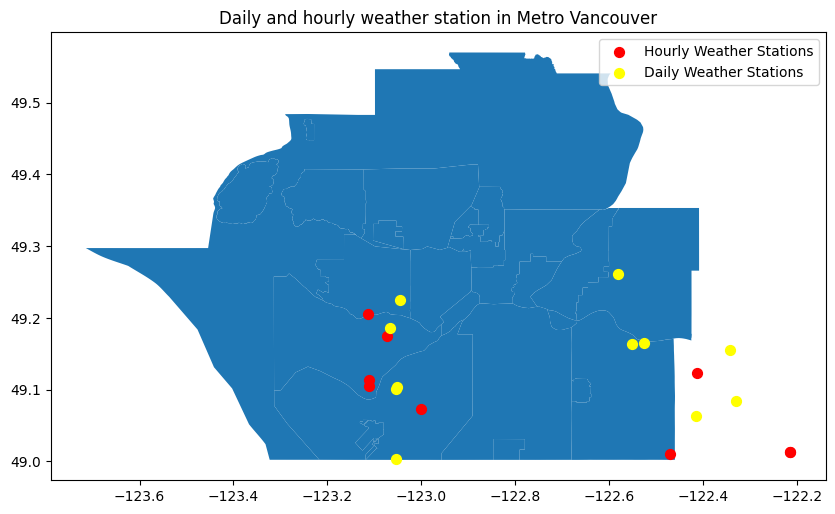

In [111]:
vancouver_map = gpd.read_file('D:\\Is-it-Vancouver-or-is-it-raincouver\\metro_van\\Administrative_Boundaries.shp')
vancouver_map = vancouver_map.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 14))
vancouver_map.plot(ax=ax)  # Plot the map
gdf_hourly.plot(ax=ax, color='red', markersize=50, label='Hourly Weather Stations')  # Plot the points
gdf_daily.plot(ax=ax, color='yellow', markersize=50, label='Daily Weather Stations')  # Plot the points
plt.legend()
plt.title("Daily and hourly weather station in Metro Vancouver")
plt.show()

In [117]:
for i in range(11):
    print(daily_latitude[i], daily_longitude[i])

49.185322 -123.0655
49.1645 -122.5253
49.08408 -122.33036
49.2615066 -122.5801007
49.16422 -122.550496
49.2252002 -123.0442004
49.1015 -123.0535
49.00394 -123.0536
49.1043 -123.0513
49.15521 -122.34234
49.063295 -122.415135


In [118]:
dataframe_filt_daily

,STN_ID,STATION_NAME,LATITUDE,LONGITUDE,ELEVATION,FIRST_DATE,LAST_DATE,HLY_FIRST_DATE,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,HAS_HOURLY_DATA
22,833,N VANCOUVER WHARVES,491853220,-1230655000,7.00,1962-01-01 00:00:00,2024-09-20,None,None,1962-03-01 00:00:00,2024-09-20 00:00:00,N
23,834,PORT MOODY GLENAYRE,491645000,-1225253000,129.50,1970-01-01 00:00:00,2024-09-20,None,None,1970-11-01 00:00:00,2024-09-20 00:00:00,N
33,43723,FORT LANGLEY TELEGRAPH TRAIL,490840800,-1223303600,76.00,2005-04-01 00:00:00,2024-09-20,None,None,2005-04-01 00:00:00,2024-09-20 00:00:00,N
46,698,N VAN SEYMOUR HATCHERY,492615066,-1225801007,177.00,1981-01-01 00:00:00,2024-09-19,None,None,1981-11-01 00:00:00,2024-09-19 00:00:00,N
51,731,BURNABY SIMON FRASER U,491642200,-1225504960,365.80,1965-01-01 00:00:00,2022-06-04,None,None,1965-02-01 00:00:00,2022-06-04 00:00:00,N
59,823,N VANC GROUSE MTN RESORT,492252002,-1230442004,1103.00,1971-01-01 00:00:00,2024-09-11,None,None,1971-10-01 00:00:00,2024-09-11 00:00:00,N
61,837,RICHMOND NATURE PARK,491015000,-1230535000,3.00,1977-01-01 00:00:00,2024-09-20,None,None,1977-03-01 00:00:00,2024-09-20 00:00:00,N
141,766,DELTA TSAWWASSEN BEACH,490039400,-1230536000,2.40,1971-01-01 00:00:00,2024-08-21,None,None,1971-03-01 00:00:00,2024-08-21 00:00:00,N
152,853,RICHMOND DALLYN 2,491043000,-1230513000,1.80,1963-01-01 00:00:00,2024-09-20,None,None,1963-11-01 00:00:00,2024-09-20 00:00:00,N
194,776,HANEY UBC RF ADMIN,491552100,-1223423400,147.00,1961-01-01 00:00:00,2024-05-30,None,None,1961-10-01 00:00:00,2024-05-30 00:00:00,N
